# Practicing Transfer learning

In [106]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import logging
import PIL.Image as Image
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers,models

In [107]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Part 1 - Tensorflow hub MobileNet

In [108]:
CLASSIFIER_URL = "https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/tf2-preview-classification/2?tfhub-redirect=true"
IMAGES_RES =224

model= tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=True,
    weights='imagenet'
)

### Testing the model on image form the image

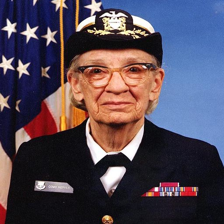

In [109]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper =Image.open(grace_hopper).resize((IMAGES_RES,IMAGES_RES))
grace_hopper

In [110]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

### Predicting the image (but with no label)

In [111]:
result = model.predict(grace_hopper[np.newaxis,...])
result.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


(1, 1000)

In [112]:
predicted_class = np.argmax(result)
predicted_class

652

### Downloading the labels

In [113]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt') 
imagnet_labels = np.array(open(labels_path).read().splitlines())

Microwave


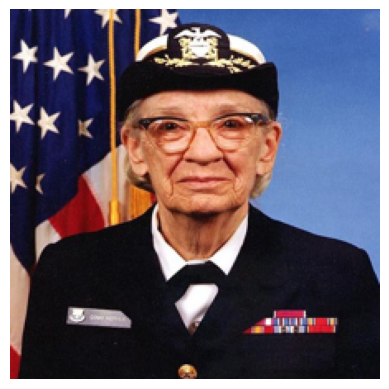

In [114]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagnet_labels[predicted_class]
print(predicted_class_name.title())

### Using Transfer learning on Cats & Dogs

In [115]:
base_dir = r"S:\vscode\Machine Learning\Tensorflow_basics\cats_vs_dogs\cats_and_dogs_filtered"

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

test_dir=os.path.join(base_dir,'test')
test_cats_dir=os.path.join(test_dir,'cats')
test_dogs_dir=os.path.join(test_dir,'dogs')

os.makedirs(test_cats_dir,exist_ok=True)
os.makedirs(test_dogs_dir,exist_ok=True)

data_dirs = [train_dir,validation_dir,test_dir]
sub_dirs= ['cats','dogs']
for d in data_dirs:
    for s in sub_dirs:
        folder = os.path.join(d,s)
        count=len(os.listdir(folder))
        short_path = os.path.basename(d)+'/'+s
        print(f"No. of images in {short_path} :{count}" )

No. of images in train/cats :1000
No. of images in train/dogs :1000
No. of images in validation/cats :250
No. of images in validation/dogs :250
No. of images in test/cats :250
No. of images in test/dogs :250


In [116]:
IMAGE_SIZE =(224,224)
BATCH_SIZE = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,image_size=IMAGE_SIZE,batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,image_size=IMAGE_SIZE,batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,image_size=IMAGE_SIZE,batch_size=BATCH_SIZE
)

Found 2000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [117]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds=train_ds.map(lambda x,y:(normalization_layer(x),y))
val_ds=val_ds.map(lambda x,y:(normalization_layer(x),y))
test_ds=test_ds.map(lambda x,y:(normalization_layer(x),y))

In [118]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
])



train_ds = train_ds.map(lambda x,y:(data_augmentation(x,training=True),y))

In [119]:
feature_extractor = MobileNetV2(
    input_shape = (IMAGES_RES,IMAGES_RES,3),
    include_top=False,
    weights='imagenet'
)

feature_extractor.trainable = False

In [120]:
model = models.Sequential([
    layers.InputLayer(input_shape=(IMAGES_RES,IMAGES_RES,3)),
    data_augmentation,
    layers.Lambda(preprocess_input),
    feature_extractor,
    layers.GlobalAveragePooling2D(),
    layers.Dense(2)
    ])

In [121]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [122]:
history = model.fit(
    train_ds,
    epochs=6,
    validation_data=val_ds
)

Epoch 1/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 826ms/step - accuracy: 0.4865 - loss: 0.7185 - val_accuracy: 0.5540 - val_loss: 0.6870
Epoch 2/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 710ms/step - accuracy: 0.5090 - loss: 0.6936 - val_accuracy: 0.5020 - val_loss: 0.6882
Epoch 3/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 732ms/step - accuracy: 0.5140 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.7047
Epoch 4/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 758ms/step - accuracy: 0.5050 - loss: 0.7011 - val_accuracy: 0.5440 - val_loss: 0.6842
Epoch 5/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 743ms/step - accuracy: 0.5250 - loss: 0.6902 - val_accuracy: 0.5000 - val_loss: 0.7020
Epoch 6/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 783ms/step - accuracy: 0.5210 - loss: 0.7045 - val_accuracy: 0.5380 - val_loss: 0.6821


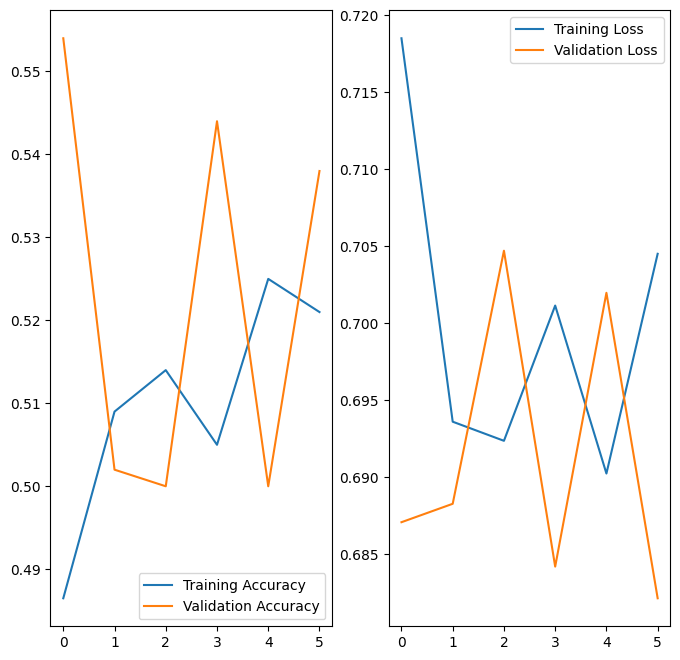

In [125]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
#plt.title('Training and Validation Loss')
plt.show()